In [1]:
import pandas as pd
import numpy as np
import csv
import datetime
from datetime import date, time, datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import gspread
import re

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
np.random.seed(42)
import itertools
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from xgboost import XGBClassifier
from xgboost import XGBRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [2]:
#Things to try - 1: Combing numerical data, Target encoding, creating polynomial features, bins from numerical values, Using KNN imputer to fill missing values
#Things that improved accuracy - Combining categorical variables, encoding variables, adding group wise means of credit scores, changing less used values to Rare (slightly),  Checking ordinal values treatment,
#things that did not work - 
#2: Try different ML algorithms, try out ensemble with mean, try out DNN, try out hybrid DNN + RF

trainDataRaw = pd.read_csv("/content/drive/MyDrive/AI ML Projects/Cipla/dataset/train.csv")
testDataRaw = pd.read_csv("/content/drive/MyDrive/AI ML Projects/Cipla/dataset/test.csv")

In [3]:
def getFeatures(df):
    num_features = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_features = df.select_dtypes(include=[np.object]).columns.tolist()
    return num_features,cat_features

def equalLists(array1, array2):
  an_array = np.array(array1)
  another_array = np.array(array2)    
  comparison = an_array == another_array
  equal_arrays = comparison.all()    
  return equal_arrays

def feature_engineering(df, cat_cols):
  """
  This function is used for feature engineering
  :param df: the pandas dataframe with train/test data
  :param cat_cols: list of categorical columns
  :return: dataframe with new features
  """
  # this will create all 2-combinations of values
  # in this list
  # for example:
  # list(itertools.combinations([1,2,3], 2)) will return
  # [(1, 2), (1, 3), (2, 3)]
  combi = list(itertools.combinations(cat_cols, 2))
  for c1, c2 in combi:
    df.loc[
    :,
    c1 + "_" + c2
    ] = df[c1].astype(str) + "_" + df[c2].astype(str)
  return df

def comparing_train_and_test_feature(df,df_test,col):
    fig = plt.figure(figsize=(16,10))
    ax0 = fig.add_subplot(1,2,1)
    ax1 = fig.add_subplot(1,2,2)
    df[col].plot(kind='kde',ax=ax0)
    df_test[col].plot(kind='kde',ax=ax1)
    ax0.set_xlabel(col)
    ax1.set_xlabel(col)
    ax0.set_title("Density plot of " + str(col) + " of training set")
    ax1.set_title("Density plot of " + str(col) + " of testing set")
    plt.show()

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values


In [4]:
testDataRawcopy = testDataRaw.copy()

testDataRawcopy["Loan Sanction Amount (USD)"] = -1
print(equalLists(testDataRawcopy.columns.tolist(),trainDataRaw.columns.tolist() ))

True


In [5]:
trainDataRaw.nunique()
trainDataRawPro = trainDataRaw.copy()
trainDataRawPro2 = trainDataRaw.copy()
testDataRawPro2 = testDataRawcopy.copy()
testDataRawPro = testDataRawcopy.copy()


In [6]:
#trainDataRawPro.drop("LoandiffSancReq", axis=1, inplace = True)
trainDataRawPro.loc[trainDataRawPro["Loan Sanction Amount (USD)"] < 0, "Loan Sanction Amount (USD)"] = 0
trainDataRawPro2.loc[trainDataRawPro2["Loan Sanction Amount (USD)"] < 0, "Loan Sanction Amount (USD)"] = 0
#testDataRawPro[testDataRawPro["Loan Sanction Amount (USD)"] < 0]["Loan Sanction Amount (USD)"] = 0
#trainDataRawPro[trainDataRawPro["Loan Sanction Amount (USD)"] < 0]["Loan Sanction Amount (USD)"] = 0

trainDataRawPro["LoandiffReqSanc"] = (trainDataRawPro["Loan Amount Request (USD)"] - trainDataRawPro["Loan Sanction Amount (USD)"]) / trainDataRawPro["Loan Amount Request (USD)"]
trainDataRawPro2["LoandiffReqSanc"] = (trainDataRawPro2["Loan Amount Request (USD)"] - trainDataRawPro2["Loan Sanction Amount (USD)"]) / trainDataRawPro2["Loan Amount Request (USD)"]
testDataRawPro["LoandiffReqSanc"] = (testDataRawPro["Loan Amount Request (USD)"] - testDataRawPro["Loan Sanction Amount (USD)"]) / testDataRawPro["Loan Amount Request (USD)"]
testDataRawPro2["LoandiffReqSanc"] = (testDataRawPro2["Loan Amount Request (USD)"] - testDataRawPro2["Loan Sanction Amount (USD)"])/ testDataRawPro2["Loan Amount Request (USD)"]
#trainDataRawPro["LoandiffReqSancPercent"] = trainDataRawPro["LoandiffReqSanc"] / trainDataRawPro["Loan Amount Request (USD)"]
#trainDataRawPro["LoandiffReqSancPercent"].describe()

In [ ]:
#trainDataRawPro.loc[trainDataRawPro["Loan Sanction Amount (USD)"] < 0].count()
max(trainDataRawPro["LoandiffReqSanc"])

1.0

In [7]:
#testDataRawPro2["Property Price"].value_counts()
#print(testDataRawPro2.loc[~testDataRawPro2["Property Price"].isin(["?"])]["Property Price"].median())
testDataRawPro2["Property Price"] = testDataRawPro2["Property Price"].replace(['?'],testDataRawPro2.loc[~testDataRawPro2["Property Price"].isin(["?"])]["Property Price"].median())
testDataRawPro2["Property Price"] = pd.to_numeric(testDataRawPro2["Property Price"])
testDataRawPro2["Co-Applicant"] = testDataRawPro2["Co-Applicant"].replace(['?'],testDataRawPro2.loc[~testDataRawPro2["Co-Applicant"].isin(["?"])]["Co-Applicant"].median())
testDataRawPro2["Co-Applicant"] = pd.to_numeric(testDataRawPro2["Co-Applicant"])

testDataRawPro["Property Price"] = testDataRawPro["Property Price"].replace(['?'],testDataRawPro.loc[~testDataRawPro["Property Price"].isin(["?"])]["Property Price"].median())
testDataRawPro["Property Price"] = pd.to_numeric(testDataRawPro["Property Price"])
testDataRawPro["Co-Applicant"] = testDataRawPro["Co-Applicant"].replace(['?'],testDataRawPro.loc[~testDataRawPro["Co-Applicant"].isin(["?"])]["Co-Applicant"].median())
testDataRawPro["Co-Applicant"] = pd.to_numeric(testDataRawPro["Co-Applicant"])

print(testDataRawPro2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  20000 non-null  object 
 1   Name                         20000 non-null  object 
 2   Gender                       19969 non-null  object 
 3   Age                          20000 non-null  int64  
 4   Income (USD)                 19250 non-null  float64
 5   Income Stability             19187 non-null  object 
 6   Profession                   20000 non-null  object 
 7   Type of Employment           15311 non-null  object 
 8   Location                     20000 non-null  object 
 9   Loan Amount Request (USD)    20000 non-null  float64
 10  Current Loan Expenses (USD)  19917 non-null  float64
 11  Expense Type 1               20000 non-null  object 
 12  Expense Type 2               20000 non-null  object 
 13  Dependents      

In [8]:
trainDataRawPro['Credit Score scaled'] = trainDataRawPro["Credit Score"] - 550
trainDataRawPro['Credit Score scaled more than 300'] = trainDataRawPro['Credit Score scaled'].apply(lambda x: 1 if x >= 300 else 0) 
trainDataRawPro["Co-Applicant-No. of Defaults Combo"] = trainDataRawPro.apply(lambda row: 0 if (row["Co-Applicant"] ==1) else 1 if (row["No. of Defaults"] == 0) else 2, axis = 1)
#trainDataRawPro["Property Age"] = trainDataRawPro['Property Age'].apply(lambda x: 0 if x >= 2000 else 1)
trainDataRawPro["Property Price-Credit Score scaled Combo"] = trainDataRawPro.apply(lambda row: 4 if (row["Property Price"] <= 150000.00 and row["Credit Score scaled"] >=150.00) else 3 if (row["Property Price"] <= 150000.00 and row["Credit Score scaled"] <=150.00) else 2 if (row["Property Price"] > 150000.00 and row["Credit Score scaled"] > 150.00) else 1, axis = 1)
trainDataRawPro.loc[trainDataRawPro["Property Age"] >= 8000, "Property Age"] = 8000
#trainDataRawPro.loc[trainDataRawPro["Current Loan Expenses (USD)"] >=2200, "Current Loan Expenses (USD)"] = 2200
trainDataRawPro.loc[trainDataRawPro["Co-Applicant"] == -999, "Co-Applicant"] = 1
trainDataRawPro.loc[trainDataRawPro["Property Price"] >= 500000, "Property Price"] = 500000

testDataRawPro['Credit Score scaled'] = testDataRawPro["Credit Score"] - 550
testDataRawPro['Credit Score scaled more than 300'] = testDataRawPro['Credit Score scaled'].apply(lambda x: 1 if x >= 300 else 0) 
testDataRawPro["Co-Applicant-No. of Defaults Combo"] = testDataRawPro.apply(lambda row: 0 if (row["Co-Applicant"] ==1) else 1 if (row["No. of Defaults"] == 0) else 2, axis = 1)
#testDataRawPro["Property Age"] = testDataRawPro['Property Age'].apply(lambda x: 0 if x >= 2000 else 1)
testDataRawPro["Property Price-Credit Score scaled Combo"] = testDataRawPro.apply(lambda row: 4 if (row["Property Price"] <= 150000.00 and row["Credit Score scaled"] >=150.00) else 3 if (row["Property Price"] <= 150000.00 and row["Credit Score scaled"] <=150.00) else 2 if (row["Property Price"] > 150000.00 and row["Credit Score scaled"] > 150.00) else 1, axis = 1)
testDataRawPro.loc[testDataRawPro["Property Age"] >= 8000, "Property Age"] = 8000
#testDataRawPro.loc[testDataRawPro["Current Loan Expenses (USD)"] >=2200, "Current Loan Expenses (USD)"] = 2200
testDataRawPro.loc[testDataRawPro["Co-Applicant"] == -999, "Co-Applicant"] = 1
testDataRawPro.loc[testDataRawPro["Property Price"] >= 500000, "Property Price"] = 500000



In [9]:
trainDataRawPro2['Credit Score scaled'] = trainDataRawPro2["Credit Score"] - 550
trainDataRawPro2['Credit Score scaled more than 300'] = trainDataRawPro2['Credit Score scaled'].apply(lambda x: 1 if x >= 300 else 0) 
trainDataRawPro2["Co-Applicant-No. of Defaults Combo"] = trainDataRawPro2.apply(lambda row: 0 if (row["Co-Applicant"] ==1) else 1 if (row["No. of Defaults"] == 0) else 2, axis = 1)
#trainDataRawPro2["Property Age"] = trainDataRawPro2['Property Age'].apply(lambda x: 0 if x >= 2000 else 1)
trainDataRawPro2["Property Price-Credit Score scaled Combo"] = trainDataRawPro2.apply(lambda row: 4 if (row["Property Price"] <= 150000.00 and row["Credit Score scaled"] >=150.00) else 3 if (row["Property Price"] <= 150000.00 and row["Credit Score scaled"] <=150.00) else 2 if (row["Property Price"] > 150000.00 and row["Credit Score scaled"] > 150.00) else 1, axis = 1)
trainDataRawPro2.loc[trainDataRawPro2["Property Age"] >= 8000, "Property Age"] = 8000
#trainDataRawPro2.loc[trainDataRawPro2["Current Loan Expenses (USD)"] >=2200, "Current Loan Expenses (USD)"] = 2200
trainDataRawPro2.loc[trainDataRawPro2["Co-Applicant"] == -999, "Co-Applicant"] = 1
trainDataRawPro2.loc[trainDataRawPro2["Property Price"] >= 500000, "Property Price"] = 500000

testDataRawPro2['Credit Score scaled'] = testDataRawPro2["Credit Score"] - 550
testDataRawPro2['Credit Score scaled more than 300'] = testDataRawPro2['Credit Score scaled'].apply(lambda x: 1 if x >= 300 else 0) 
testDataRawPro2["Co-Applicant-No. of Defaults Combo"] = testDataRawPro2.apply(lambda row: 0 if (row["Co-Applicant"] ==1) else 1 if (row["No. of Defaults"] == 0) else 2, axis = 1)
#testDataRawPro2["Property Age"] = testDataRawPro2['Property Age'].apply(lambda x: 0 if x >= 2000 else 1)
testDataRawPro2["Property Price-Credit Score scaled Combo"] = testDataRawPro2.apply(lambda row: 4 if (row["Property Price"] <= 150000.00 and row["Credit Score scaled"] >=150.00) else 3 if (row["Property Price"] <= 150000.00 and row["Credit Score scaled"] <=150.00) else 2 if (row["Property Price"] > 150000.00 and row["Credit Score scaled"] > 150.00) else 1, axis = 1)
testDataRawPro2.loc[testDataRawPro2["Property Age"] >= 8000, "Property Age"] = 8000
#testDataRawPro2.loc[testDataRawPro2["Current Loan Expenses (USD)"] >=2200, "Current Loan Expenses (USD)"] = 2200
testDataRawPro2.loc[testDataRawPro2["Co-Applicant"] == -999, "Co-Applicant"] = 1
testDataRawPro2.loc[testDataRawPro2["Property Price"] >= 500000, "Property Price"] = 500000


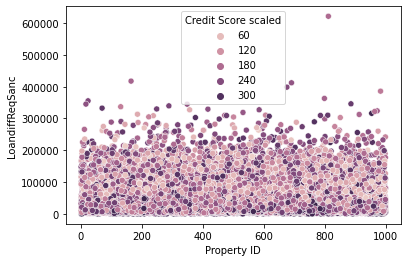

In [ ]:
#Numerical EDA
#Summary - There seems to be a step jump in Credit Score Scaled > 300 - Create a Bin for that; Map Co-Applicant  No. of Defaults as a new variable - with (1,0) and (1,1) mapping to 0, (0,0) mapping to 1, and (0,1) mapping to 2; Create a bin for Property Age > 2000 and <= 2000; Property Price and Credit ScoreScaled mapping - <150000 and > 150 - score 4; <150000 and < 150 - score 3, > 150000 and > 150 - score 2, > 150000 and < 150 - score 1; 
#Outliers check -  Current Loan Expenses (USD) - Remove above 2200 and less than 0, Co-Applicant = -999 (change to 1) since mean of -999 is closer to 1, Property Age - More than 8000 to 8000 , Property Price - more than 500000 = 500000, 
#sns.scatterplot(x='Property ID',y='LoandiffReqSanc',hue='Credit Score scaled',data=trainDataRawPro) #
#sns.scatterplot(x='Credit Score scaled',y='Current Loan Expenses (USD)',data=trainDataRawPro)
#print(trainDataRawPro.loc[trainDataRawPro["Credit Score scaled"] >= 300].LoandiffReqSanc.mean(), "\n")
#print(trainDataRawPro.loc[trainDataRawPro["Credit Score scaled"] < 300].LoandiffReqSanc.mean(), "\n")
#print(trainDataRawPro.loc[trainDataRawPro["Current Loan Expenses (USD)"] < 0].LoandiffReqSanc.mean(), "\n")
#print(trainDataRawPro.groupby("Co-Applicant")["LoandiffReqSanc"].mean())
#print(trainDataRawPro.loc[(trainDataRawPro["Co-Applicant"] == 1) & (trainDataRawPro["No. of Defaults"] == 1)].LoandiffReqSanc.mean(), "\n")
#print(trainDataRawPro.loc[(trainDataRawPro["Co-Applicant"] == 0) & (trainDataRawPro["No. of Defaults"] == 1)].LoandiffReqSanc.mean(), "\n")
#print(trainDataRawPro.groupby(by = ["No. of Defaults", "Co-Applicant"]).LoandiffReqSanc.mean())
#print(trainDataRawPro.groupby(by = ["Property Type", "Property Age"]).LoandiffReqSanc.mean())
#print("Quantiles: " , trainDataRawPro["Property Age"].quantile([.1, .25, .5, .99]), "\n Max values:\n ", trainDataRawPro["Property Age"].max())
#maxer = []
#for i in range (1000,7000, 1000):
#  maxer.append(trainDataRawPro.loc[trainDataRawPro["Property Age"] > i].LoandiffReqSanc.mean() - trainDataRawPro.loc[trainDataRawPro["Property Age"] <= i].LoandiffReqSanc.mean())
#print(maxer)
#print(trainDataRawPro.loc[trainDataRawPro["Property Age"] <= 2000].LoandiffReqSanc.mean(), "\n")
#print(trainDataRawPro.loc[trainDataRawPro["Property Age"] > 2000].LoandiffReqSanc.mean(), "\n")
#print(trainDataRawPro.loc[trainDataRawPro["Property Age"] <= 2000].count(), "\n")
#print(trainDataRawPro.loc[trainDataRawPro["Property Age"] > 2000].count(), "\n")
#print("Quantiles: " , trainDataRawPro["Property Price"].quantile([.1, .25, .5, .75]), "\n Max values:\n ", trainDataRawPro["Property Price"].max())
#print(trainDataRawPro.loc[(trainDataRawPro["Property Price"] > 150000) & (trainDataRawPro["Credit Score scaled"] < 150)].LoandiffReqSanc.mean(), "\n")
#print(trainDataRawPro.loc[(trainDataRawPro["Property Price"] > 150000) & (trainDataRawPro["Credit Score scaled"] > 150)].LoandiffReqSanc.mean(), "\n")
#print(trainDataRawPro.loc[(trainDataRawPro["Property Price"] < 150000) & (trainDataRawPro["Credit Score scaled"] < 150)].LoandiffReqSanc.mean(), "\n")
#print(trainDataRawPro.loc[(trainDataRawPro["Property Price"] < 150000) & (trainDataRawPro["Credit Score scaled"] > 150)].LoandiffReqSanc.mean(), "\n")
#print(trainDataRawPro["Property ID"].nunique())


In [ ]:
num_attribs,cat_attribs = getFeatures(trainDataRawPro)
num_attribs_test,cat_attribs_test = getFeatures(testDataRaw)

In [10]:
num_attribs,cat_attribs = getFeatures(trainDataRawPro2)
trainDataRawPro2[cat_attribs] = trainDataRawPro2[cat_attribs].fillna(value="unknown")
trainDataRawPro2[num_attribs] = trainDataRawPro2[num_attribs].fillna(trainDataRawPro2[num_attribs].median())
trainDataRawPro2.loc[ 
       trainDataRawPro2["Profession"].value_counts()[trainDataRawPro2["Profession"]].values < 100,
       "Profession"
       ] = "RARE"
trainDataRawPro2.loc[ 
       trainDataRawPro2["Type of Employment"].value_counts()[trainDataRawPro2["Type of Employment"]].values < 300,
       "Type of Employment"
       ] = "RARE"
label_encoder = preprocessing.LabelEncoder()
trainDataRawPro2["Income Stability num"]= label_encoder.fit_transform(trainDataRawPro2["Income Stability"])
print(trainDataRawPro2["Income Stability num"].describe())
print(trainDataRawPro2.columns.tolist())
cat_drop_list = ['Customer ID',
 'Name',
]
cat_attribs_selector = [
 'Gender',
 'Income Stability',
 'Profession',
 'Type of Employment',
 'Location',
 'Expense Type 1',
 'Expense Type 2',
 'Has Active Credit Card',
 'Property Location']
for col in cat_attribs_selector:
  trainDataRawPro2[str(col) + 'mean' + 'Credit_Score_scaled'] = trainDataRawPro2.groupby(col)['Credit Score scaled'].transform('mean')
  #print("column: ", col, trainDataRawPro2.groupby(col)["LoandiffReqSanc"].mean(), "\n")

num_attribs,cat_attribs = getFeatures(trainDataRawPro2)
final_cat_columns = [i for i in cat_attribs if i not in cat_drop_list]

trainDataRawPro2 = feature_engineering(trainDataRawPro2,final_cat_columns)

num_attribs,cat_attribs = getFeatures(trainDataRawPro2)
final_cat_columns = [i for i in cat_attribs if i not in cat_drop_list]
print(final_cat_columns)

count    30000.000000
mean         0.970567
std          0.375196
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: Income Stability num, dtype: float64
['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)', 'Income Stability', 'Profession', 'Type of Employment', 'Location', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score', 'No. of Defaults', 'Has Active Credit Card', 'Property ID', 'Property Age', 'Property Type', 'Property Location', 'Co-Applicant', 'Property Price', 'Loan Sanction Amount (USD)', 'LoandiffReqSanc', 'Credit Score scaled', 'Credit Score scaled more than 300', 'Co-Applicant-No. of Defaults Combo', 'Property Price-Credit Score scaled Combo', 'Income Stability num']
['Gender', 'Income Stability', 'Profession', 'Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2', 'Has Active Credit Card', 'Property Location', 'Gend

In [11]:
num_attribs,cat_attribs = getFeatures(testDataRawPro2)
testDataRawPro2[cat_attribs] = testDataRawPro2[cat_attribs].fillna(value="unknown")
testDataRawPro2[num_attribs] = testDataRawPro2[num_attribs].fillna(testDataRawPro2[num_attribs].median())
testDataRawPro2.loc[ 
       testDataRawPro2["Profession"].value_counts()[testDataRawPro2["Profession"]].values < 100,
       "Profession"
       ] = "RARE"
testDataRawPro2.loc[ 
       testDataRawPro2["Type of Employment"].value_counts()[testDataRawPro2["Type of Employment"]].values < 300,
       "Type of Employment"
       ] = "RARE"
label_encoder = preprocessing.LabelEncoder()
testDataRawPro2["Income Stability num"]= label_encoder.fit_transform(testDataRawPro2["Income Stability"])
print(testDataRawPro2["Income Stability num"].describe())
print(testDataRawPro2.columns.tolist())
cat_drop_list = ['Customer ID',
 'Name',
]
cat_attribs_selector = [
 'Gender',
 'Income Stability',
 'Profession',
 'Type of Employment',
 'Location',
 'Expense Type 1',
 'Expense Type 2',
 'Has Active Credit Card',
 'Property Location']
for col in cat_attribs_selector:
  testDataRawPro2[str(col) + 'mean' + 'Credit_Score_scaled'] = testDataRawPro2.groupby(col)['Credit Score scaled'].transform('mean')
  #print("column: ", col, testDataRawPro2.groupby(col)["LoandiffReqSanc"].mean(), "\n")

num_attribs,cat_attribs = getFeatures(testDataRawPro2)
final_cat_columns = [i for i in cat_attribs if i not in cat_drop_list]

testDataRawPro2 = feature_engineering(testDataRawPro2,final_cat_columns)

num_attribs,cat_attribs = getFeatures(testDataRawPro2)
final_cat_columns = [i for i in cat_attribs if i not in cat_drop_list]
print(final_cat_columns)

count    20000.000000
mean         0.956350
std          0.350786
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: Income Stability num, dtype: float64
['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)', 'Income Stability', 'Profession', 'Type of Employment', 'Location', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score', 'No. of Defaults', 'Has Active Credit Card', 'Property ID', 'Property Age', 'Property Type', 'Property Location', 'Co-Applicant', 'Property Price', 'Loan Sanction Amount (USD)', 'LoandiffReqSanc', 'Credit Score scaled', 'Credit Score scaled more than 300', 'Co-Applicant-No. of Defaults Combo', 'Property Price-Credit Score scaled Combo', 'Income Stability num']
['Gender', 'Income Stability', 'Profession', 'Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2', 'Has Active Credit Card', 'Property Location', 'Gend

In [13]:
print(cat_attribs, "\n", num_attribs)
final_num_columns = [i for i in num_attribs if i not in ["LoandiffReqSanc"] ]
final_num_columns
#testDataRawPro2[num_attribs].info()
#testDataRawPro2["Co-Applicant"].value_counts()

['Customer ID', 'Name', 'Gender', 'Income Stability', 'Profession', 'Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2', 'Has Active Credit Card', 'Property Location', 'Gender_Income Stability', 'Gender_Profession', 'Gender_Type of Employment', 'Gender_Location', 'Gender_Expense Type 1', 'Gender_Expense Type 2', 'Gender_Has Active Credit Card', 'Gender_Property Location', 'Income Stability_Profession', 'Income Stability_Type of Employment', 'Income Stability_Location', 'Income Stability_Expense Type 1', 'Income Stability_Expense Type 2', 'Income Stability_Has Active Credit Card', 'Income Stability_Property Location', 'Profession_Type of Employment', 'Profession_Location', 'Profession_Expense Type 1', 'Profession_Expense Type 2', 'Profession_Has Active Credit Card', 'Profession_Property Location', 'Type of Employment_Location', 'Type of Employment_Expense Type 1', 'Type of Employment_Expense Type 2', 'Type of Employment_Has Active Credit Card', 'Type of Employment_Prope

['Age',
 'Income (USD)',
 'Loan Amount Request (USD)',
 'Current Loan Expenses (USD)',
 'Dependents',
 'Credit Score',
 'No. of Defaults',
 'Property ID',
 'Property Age',
 'Property Type',
 'Co-Applicant',
 'Property Price',
 'Loan Sanction Amount (USD)',
 'Credit Score scaled',
 'Credit Score scaled more than 300',
 'Co-Applicant-No. of Defaults Combo',
 'Property Price-Credit Score scaled Combo',
 'Income Stability num',
 'GendermeanCredit_Score_scaled',
 'Income StabilitymeanCredit_Score_scaled',
 'ProfessionmeanCredit_Score_scaled',
 'Type of EmploymentmeanCredit_Score_scaled',
 'LocationmeanCredit_Score_scaled',
 'Expense Type 1meanCredit_Score_scaled',
 'Expense Type 2meanCredit_Score_scaled',
 'Has Active Credit CardmeanCredit_Score_scaled',
 'Property LocationmeanCredit_Score_scaled']

In [14]:
power = PowerTransformer(method='yeo-johnson', standardize=True)
scaler = StandardScaler()

trainDataRawPro2[final_num_columns] = scaler.fit_transform(trainDataRawPro2[final_num_columns])
trainDataRawPro2[final_num_columns] = power.fit_transform(trainDataRawPro2[final_num_columns])

testDataRawPro2[final_num_columns] = scaler.fit_transform(testDataRawPro2[final_num_columns])
testDataRawPro2[final_num_columns] = power.fit_transform(testDataRawPro2[final_num_columns])


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [15]:
num_attribs,cat_attribs = getFeatures(trainDataRawPro)

trainDataRawPro[cat_attribs] = trainDataRawPro[cat_attribs].fillna(value="unknown")
trainDataRawPro[num_attribs] = trainDataRawPro[num_attribs].fillna(trainDataRawPro[num_attribs].median())

testDataRawPro[cat_attribs] = testDataRawPro[cat_attribs].fillna(value="unknown")
testDataRawPro[num_attribs] = testDataRawPro[num_attribs].fillna(testDataRawPro[num_attribs].median())


In [16]:
#to convert to rare - Profession less than 100, Type of Employment - less than 300, 
trainDataRawPro.loc[ 
       trainDataRawPro["Profession"].value_counts()[trainDataRawPro["Profession"]].values < 100,
       "Profession"
       ] = "RARE"
trainDataRawPro.loc[ 
       trainDataRawPro["Type of Employment"].value_counts()[trainDataRawPro["Type of Employment"]].values < 300,
       "Type of Employment"
       ] = "RARE"
label_encoder = preprocessing.LabelEncoder()
trainDataRawPro["Income Stability num"]= label_encoder.fit_transform(trainDataRawPro["Income Stability"])
trainDataRawPro["Income Stability num"].describe()
#for col in cat_attribs:
#  print(trainDataRawPro[col].value_counts())

#to convert to rare - Profession less than 100, Type of Employment - less than 300, 
testDataRawPro.loc[ 
       testDataRawPro["Profession"].value_counts()[testDataRawPro["Profession"]].values < 100,
       "Profession"
       ] = "RARE"
testDataRawPro.loc[ 
       testDataRawPro["Type of Employment"].value_counts()[testDataRawPro["Type of Employment"]].values < 300,
       "Type of Employment"
       ] = "RARE"
label_encoder = preprocessing.LabelEncoder()
testDataRawPro["Income Stability num"]= label_encoder.fit_transform(testDataRawPro["Income Stability"])
testDataRawPro["Income Stability num"].describe()


count    20000.000000
mean         0.956350
std          0.350786
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: Income Stability num, dtype: float64

In [ ]:
#Ordinal Variables - 'Income Stability', 
for col in cat_attribs:
  print("column: ", col, trainDataRawPro.groupby(col)["LoandiffReqSanc"].mean(), "\n")

In [17]:
cat_drop_list = ['Customer ID',
 'Name',
]
cat_attribs_selector = [
 'Gender',
 'Income Stability',
 'Profession',
 'Type of Employment',
 'Location',
 'Expense Type 1',
 'Expense Type 2',
 'Has Active Credit Card',
 'Property Location']
for col in cat_attribs_selector:
  trainDataRawPro[str(col) + 'mean' + 'Credit_Score_scaled'] = trainDataRawPro.groupby(col)['Credit Score scaled'].transform('mean')
  #print("column: ", col, trainDataRawPro.groupby(col)["LoandiffReqSanc"].mean(), "\n")

num_attribs,cat_attribs = getFeatures(trainDataRawPro)
final_cat_columns = [i for i in cat_attribs if i not in cat_drop_list]

trainDataRawPro = feature_engineering(trainDataRawPro,final_cat_columns)

num_attribs,cat_attribs = getFeatures(trainDataRawPro)
final_cat_columns = [i for i in cat_attribs if i not in cat_drop_list]


cat_drop_list = ['Customer ID',
 'Name',
]
cat_attribs_selector = [
 'Gender',
 'Income Stability',
 'Profession',
 'Type of Employment',
 'Location',
 'Expense Type 1',
 'Expense Type 2',
 'Has Active Credit Card',
 'Property Location']
for col in cat_attribs_selector:
  testDataRawPro[str(col) + 'mean' + 'Credit_Score_scaled'] = testDataRawPro.groupby(col)['Credit Score scaled'].transform('mean')
  #print("column: ", col, testDataRawPro.groupby(col)["LoandiffReqSanc"].mean(), "\n")

num_attribs,cat_attribs = getFeatures(testDataRawPro)
final_cat_columns = [i for i in cat_attribs if i not in cat_drop_list]

testDataRawPro = feature_engineering(testDataRawPro,final_cat_columns)

num_attribs,cat_attribs = getFeatures(testDataRawPro)
final_cat_columns = [i for i in cat_attribs if i not in cat_drop_list]


combined_train_testRawPro = pd.concat([trainDataRawPro,testDataRawPro])

#label_encoder = LabelBinarizer()
ohe = OneHotEncoder(sparse=False, handle_unknown ='ignore') 
ohe.fit(combined_train_testRawPro[final_cat_columns])
transformed = ohe.transform(trainDataRawPro[final_cat_columns])
ohe_df = pd.DataFrame(transformed)
print(ohe_df)
trainDataRawProEncoded= pd.concat([trainDataRawPro, ohe_df], axis=1).drop(cat_attribs, axis=1)

power = PowerTransformer(method='yeo-johnson', standardize=True)
scaler = StandardScaler()

final_num_columns = [i for i in num_attribs if i not in ["LoandiffReqSanc"] ]
trainDataRawProEncoded[final_num_columns] = scaler.fit_transform(trainDataRawProEncoded[final_num_columns])
trainDataRawProEncoded[final_num_columns] = power.fit_transform(trainDataRawProEncoded[final_num_columns])

#label_encoder = LabelBinarizer()
ohe = OneHotEncoder(sparse=False, handle_unknown ='ignore') 
ohe.fit(combined_train_testRawPro[final_cat_columns])
transformed = ohe.transform(testDataRawPro[final_cat_columns])
ohe_df = pd.DataFrame(transformed)
print(ohe_df)
testDataRawProEncoded= pd.concat([testDataRawPro, ohe_df], axis=1).drop(cat_attribs, axis=1)

power = PowerTransformer(method='yeo-johnson', standardize=True)
scaler = StandardScaler()

testDataRawProEncoded[final_num_columns] = scaler.fit_transform(testDataRawProEncoded[final_num_columns])
testDataRawProEncoded[final_num_columns] = power.fit_transform(testDataRawProEncoded[final_num_columns])

print(trainDataRawProEncoded.shape, testDataRawProEncoded.shape)

       0    1    2    3    4    5    6    ...  645  646  647  648  649  650  651
0      1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0  0.0
1      0.0  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2      1.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0
3      1.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  0.0
4      1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
29995  0.0  1.0  0.0  0.0  1.0  0.0  1.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0
29996  0.0  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
29997  1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
29998  0.0  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0
29999  1.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[30000 rows x 652 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


(30000, 680) (20000, 680)


In [ ]:
trainDataRawProEncoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 671 entries, Age to 646
dtypes: float64(671)
memory usage: 153.6 MB


In [18]:
print(trainDataRawProEncoded.isna().sum().sum())
#trainDataRawPro.drop("Type of EmploymentmeanCredit_Score", axis = 1, inplace = True) 

0


In [19]:
print(trainDataRawPro2.isna().sum().sum())

0


In [ ]:
corr = trainDataRawPro.corr()
plt.figure(figsize=(20,10))
mask = np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask=mask,annot=True)
plt.show()

In [ ]:
trainDataRawPro.nunique()

In [ ]:
trainDataRawProEncoded.columns.tolist()

In [ ]:
#trainDataRawPro2
num_attribs,cat_attribs = getFeatures(trainDataRawPro2.drop(['Loan Sanction Amount (USD)', 'LoandiffReqSanc'], axis = 1))

#x_train, x_test, y_train, y_test = train_test_split(trainDataRawPro2.drop(['Loan Sanction Amount (USD)', 'LoandiffReqSanc'], axis = 1), trainDataRawPro2["LoandiffReqSanc"], test_size=0.2 )
#print(len(x_train), "train +", len(x_test), "test")


In [20]:
num_attribs,cat_attribs = getFeatures(trainDataRawProEncoded.drop(['Loan Sanction Amount (USD)', 'LoandiffReqSanc'], axis = 1))
features = num_attribs + cat_attribs
x_train_1, y_train = trainDataRawProEncoded.iloc[:20000][features], trainDataRawProEncoded.iloc[:20000]["LoandiffReqSanc"]
x_test_1, y_test = trainDataRawProEncoded.iloc[20000:][features], trainDataRawProEncoded.iloc[20000:]["LoandiffReqSanc"]
x_final_test_1, y_final_test = testDataRawProEncoded[features], testDataRawProEncoded["LoandiffReqSanc"]
#x_train, x_test, y_train, y_test = train_test_split(trainDataRawProEncoded.drop(['Loan Sanction Amount (USD)', 'LoandiffReqSanc'], axis = 1), trainDataRawProEncoded["LoandiffReqSanc"], test_size=0.2 )
#print(len(x_train), "train +", len(x_test), "test")


In [ ]:
max(y_test)

1.0

In [21]:
#cut_off = np.percentile(y_train, 95)
#y_train[y_train > cut_off] = cut_off
#y_test[y_test > cut_off] = cut_off

#y_train[y_train < 0] = 0
#y_test[y_test < 0] = 0

y_train[np.isnan(y_train)] = 0
y_test[np.isnan(y_test)] = 0



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


In [ ]:
power = PowerTransformer(method='yeo-johnson', standardize=True)
scaler = StandardScaler()

cut_off = np.percentile(y_train, 95)
y_train[y_train > cut_off] = cut_off
y_test[y_test > cut_off] = cut_off

y_train[y_train < 0] = 0
y_test[y_test < 0] = 0

y_train[np.isnan(y_train)] = 0
y_test[np.isnan(y_test)] = 0

scaled_x_train = scaler.fit_transform(x_train)
scaled_x_train = power.fit_transform(scaled_x_train)
scaled_x_test = scaler.fit_transform(x_test)
scaled_x_test = power.fit_transform(scaled_x_test)

#power2 = PowerTransformer(method='box-cox', standardize=True)

scaled_y_train = y_train / 200000.0 #scalery.fit_transform(y_train) #
scaled_y_test = y_test / 200000.0 #scalery.fit_transform(y_test) #


print(type(scaled_x_train1))

In [ ]:
print(np.percentile(y_train, 100))
print(np.percentile(y_test, 95))
print(np.percentile(y_train, 99))
#plt.hist(y_test, bins=10)
#plt.show()

In [ ]:
print(cat_attribs)
print(x_train[cat_attribs].nunique(), "\n", x_test[cat_attribs].nunique())

In [ ]:
finalTrain = full_pipeline.fit_transform(x_train)
finalTest = full_pipeline.fit_transform(x_test)
print(x_train.shape, finalTrain.shape , x_test.shape, finalTest.shape)

(24000, 66) (24000, 780) (6000, 66) (6000, 752)


In [ ]:
def hyperParameterTuningXGB(X_train, y_train):
    param_tuning = {
        'n_estimators' : [100, 250, 500, 1000], 
        'learning_rate': [0.05, 0.10, 0.20, 0.30 ] ,
        'max_depth': [ 3, 5,  10],
        'min_child_weight': [ 1, 3, 5, 7 ],
        "gamma"            : [ 0.0,  0.2 ,  0.4 ],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.3, 0.7 ],
        'objective': ['reg:squarederror']
    }
 
 
    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [ ]:
params = hyperParameterTuningXGB(x_train, y_train)
params

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 70.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 256.2min


In [ ]:
#old accuracy - 0.7118597385334986
XGBModel = XGBRegressor(n_estimators=250,max_depth=10,booster='gbtree',n_jobs=-1,learning_rate=0.05,reg_lambda=0.01,reg_alpha=0.3, colsample_bytree =  0.7, gamma = 0.0, min_child_weight = 7, objective = 'reg:squarederror', subsample = 0.7)
#XGBModel = XGBRegressor(params)
XGBModel.fit(x_train_1, y_train, 
        early_stopping_rounds=1000, eval_metric="rmse", eval_set=[(x_test_1, y_test)], verbose=True, 
        )

ypredXgb = XGBModel.predict(x_train_1)
print("Train Accuracy Score " , r2_score(y_train, ypredXgb) )

ypredTestypredXgb = XGBModel.predict(x_test_1)
print("Test Accuracy Score " , r2_score(y_test, ypredTestypredXgb) )

ypredFinalXgb = XGBModel.predict(x_final_test_1)

[0]	validation_0-rmse:0.311873
Will train until validation_0-rmse hasn't improved in 1000 rounds.
[1]	validation_0-rmse:0.30287
[2]	validation_0-rmse:0.294537
[3]	validation_0-rmse:0.289773
[4]	validation_0-rmse:0.284902
[5]	validation_0-rmse:0.277903
[6]	validation_0-rmse:0.273507
[7]	validation_0-rmse:0.267368
[8]	validation_0-rmse:0.26165
[9]	validation_0-rmse:0.256579
[10]	validation_0-rmse:0.2518
[11]	validation_0-rmse:0.247491
[12]	validation_0-rmse:0.243398
[13]	validation_0-rmse:0.239808
[14]	validation_0-rmse:0.237594
[15]	validation_0-rmse:0.234458
[16]	validation_0-rmse:0.23152
[17]	validation_0-rmse:0.228902
[18]	validation_0-rmse:0.226489
[19]	validation_0-rmse:0.224315
[20]	validation_0-rmse:0.222252
[21]	validation_0-rmse:0.221967
[22]	validation_0-rmse:0.220066
[23]	validation_0-rmse:0.219383
[24]	validation_0-rmse:0.217691
[25]	validation_0-rmse:0.216232
[26]	validation_0-rmse:0.214897
[27]	validation_0-rmse:0.213735
[28]	validation_0-rmse:0.212738
[29]	validation_0-rm

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(x_train,y_train)
y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)
print("Train Accuracy Score " , r2_score(y_train,y_train_pred))
print("Test Accuracy Score " , r2_score(y_test,y_test_pred))

Train Accuracy Score  0.9576147229869424
Train Accuracy Score  0.6984786452380077


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(criterion='mse',random_state=0,max_depth=5,
                                     n_estimators=500,min_samples_split=2,min_samples_leaf=2)
gb_model.fit(x_train_1,y_train)
y_train_pred = gb_model.predict(x_train_1)
y_test_pred = gb_model.predict(x_test_1)
print("Train Accuracy Score " ,r2_score(y_train,y_train_pred))
print("Test Accuracy Score " ,r2_score(y_test,y_test_pred))

Train Accuracy Score  0.7833193519287986
Test Accuracy Score  0.5826339566033611


In [ ]:
import lightgbm as lgb 
lgbm_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'rmse'],
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 10,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 1000
}

new_params = {
    'boosting_type': 'dart',
 'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 500,
 'num_leaves': 30,
 'objective': 'regression',
 'sub_feature': 0.8,
 'subsample': 0.7
}

#gbm = lgb.LGBMRegressor(**lgbm_params)
#gbm.fit(x_train, y_train,
#        eval_set=[(x_test, y_test)],
#        eval_metric='l1',
#        early_stopping_rounds=1000)

#ypredGbm = gbm.predict(x_train, num_iteration=gbm.best_iteration_)
#print("Train Accuracy Score " , r2_score(y_train, ypredGbm) )

#ypredTestGbm = gbm.predict(x_test, num_iteration=gbm.best_iteration_)
#print("Test Accuracy Score " , r2_score(y_test, ypredTestGbm) )

gbm = lgb.LGBMRegressor(**new_params)
gbm.fit(x_train_1, y_train,
        eval_set=[(x_test_1, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

ypredGbm = gbm.predict(x_train_1, num_iteration=gbm.best_iteration_)
print("Train Accuracy Score with new params" , r2_score(y_train, ypredGbm) )

ypredTestGbm = gbm.predict(x_test_1, num_iteration=gbm.best_iteration_)
print("Test Accuracy Score with new params" , r2_score(y_test, ypredTestGbm) )

[1]	valid_0's l2: 0.0909434	valid_0's l1: 0.26635
[2]	valid_0's l2: 0.0813346	valid_0's l1: 0.25086
[3]	valid_0's l2: 0.0737726	valid_0's l1: 0.237288
[4]	valid_0's l2: 0.0674611	valid_0's l1: 0.224742
[5]	valid_0's l2: 0.0623279	valid_0's l1: 0.213437
[6]	valid_0's l2: 0.0582146	valid_0's l1: 0.203348
[7]	valid_0's l2: 0.0549649	valid_0's l1: 0.194458
[8]	valid_0's l2: 0.0567318	valid_0's l1: 0.199378
[9]	valid_0's l2: 0.0535943	valid_0's l1: 0.190549
[10]	valid_0's l2: 0.051127	valid_0's l1: 0.182769
[11]	valid_0's l2: 0.0491254	valid_0's l1: 0.175738
[12]	valid_0's l2: 0.0500598	valid_0's l1: 0.179112
[13]	valid_0's l2: 0.0483542	valid_0's l1: 0.172693
[14]	valid_0's l2: 0.0469586	valid_0's l1: 0.166901
[15]	valid_0's l2: 0.0458248	valid_0's l1: 0.161689
[16]	valid_0's l2: 0.0448443	valid_0's l1: 0.15686
[17]	valid_0's l2: 0.0442706	valid_0's l1: 0.153888
[18]	valid_0's l2: 0.0435935	valid_0's l1: 0.149926
[19]	valid_0's l2: 0.0430078	valid_0's l1: 0.146362
[20]	valid_0's l2: 0.0425

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[35]	valid_0's l2: 0.040988	valid_0's l1: 0.12782
[36]	valid_0's l2: 0.0412301	valid_0's l1: 0.131023
[37]	valid_0's l2: 0.0411202	valid_0's l1: 0.129551
[38]	valid_0's l2: 0.0410113	valid_0's l1: 0.128125
[39]	valid_0's l2: 0.04095	valid_0's l1: 0.127339
[40]	valid_0's l2: 0.0410257	valid_0's l1: 0.128457
[41]	valid_0's l2: 0.0411871	valid_0's l1: 0.13062
[42]	valid_0's l2: 0.0410981	valid_0's l1: 0.129137
[43]	valid_0's l2: 0.0411979	valid_0's l1: 0.130443
[44]	valid_0's l2: 0.041084	valid_0's l1: 0.128966
[45]	valid_0's l2: 0.0409935	valid_0's l1: 0.12763
[46]	valid_0's l2: 0.0439166	valid_0's l1: 0.11676
[47]	valid_0's l2: 0.0432749	valid_0's l1: 0.116329
[48]	valid_0's l2: 0.0431129	valid_0's l1: 0.11724
[49]	valid_0's l2: 0.043168	valid_0's l1: 0.118737
[50]	valid_0's l2: 0.0433321	valid_0's l1: 0.120099
[51]	valid_0's l2: 0.0427949	valid_0's l1: 0.119598
[52]	valid_0's l2: 0.0423605	valid_0's l1: 0.119115
[53]	valid_0's l2: 0.0425639	valid_0's l1: 0.120784
[54]	valid_0's l2: 0.0

In [ ]:
import sklearn.base as skb
class MixModel(skb.BaseEstimator,skb.RegressorMixin,skb.TransformerMixin):
    def __init__(self,algs):
        self.algs = algs
    def fit(self,X,y):
        self.algs_ = [skb.clone(x) for x in self.algs]
        for alg in self.algs_:
            alg.fit(X,y)
        return self
    def predict(self,X):
        predictions = np.column_stack([
            stacked_model.predict(X) for stacked_model in self.algs_
        ])
        return np.mean(predictions,axis=1)

In [ ]:
mixed_model = MixModel(algs = [XGBModel, gbm,gb_model])
mixed_model.fit(x_train_1, y_train)
y_train_pred = mixed_model.predict(x_train_1)
y_test_pred = mixed_model.predict(x_test_1)
y_test_final_mixed = mixed_model.predict(x_final_test_1)
print(r2_score(y_train,y_train_pred))
print(r2_score(y_test,y_test_pred))

0.7789994777624821
0.5978882919787528


In [ ]:
testDataRawcopy["LoandiffReqSanc"] = ypredFinalXgb
#testDataRawcopy["Loan Sanction Amount (USD)"] = testDataRawcopy["Loan Amount Request (USD)"] - testDataRawcopy["LoandiffReqSanc"]
testDataRawcopy["Loan Sanction Amount (USD)"] = testDataRawcopy["Loan Amount Request (USD)"] * (1 - testDataRawcopy["LoandiffReqSanc"])
columnDropper = [
 'Name',
 'Gender',
 'Age',
 'Income (USD)',
 'Income Stability',
 'Profession',
 'Type of Employment',
 'Location',
 'Loan Amount Request (USD)',
 'Current Loan Expenses (USD)',
 'Expense Type 1',
 'Expense Type 2',
 'Dependents',
 'Credit Score',
 'No. of Defaults',
 'Has Active Credit Card',
 'Property ID',
 'Property Age',
 'Property Type',
 'Property Location',
 'Co-Applicant',
 'Property Price',
 'LoandiffReqSanc']
testDataRawcopy.drop(columnDropper, axis=1).to_csv("/content/drive/MyDrive/AI ML Projects/Cipla/dataset/submission4.csv", index = False)

In [22]:
num_attribs,cat_attribs = getFeatures(trainDataRawPro2.drop(['Loan Sanction Amount (USD)', 'LoandiffReqSanc'], axis = 1))
cat_drop_list = ['Customer ID',
 'Name',
]
final_cat_columns = [i for i in cat_attribs if i not in cat_drop_list]
print(trainDataRawPro2.shape)
combined_train_testRawPro2 = pd.concat([trainDataRawPro2,testDataRawPro2])
#converting data to list format to match the network structure
def preproc(X_train, X_val, X_test, cat_attribs ):#, ):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    print("number of cat columns: ", len(cat_attribs))
    #the cols to be embedded: rescaling to range [0, # values)
    for c in cat_attribs:
        raw_vals = np.unique(X_train[c] + X_val[c] + X_test[c] )
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).fillna(0).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)

    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in cat_attribs)]
    print("number of non-cat columns: ", len(other_cols))
    #for notc in other_cols:
    #  input_list_train.append(X_train[notc].values)
    #  input_list_val.append(X_val[notc].values)
     
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val, input_list_test

for categorical_var in trainDataRawPro2[final_cat_columns]:
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'  
    no_of_unique_cat  = combined_train_testRawPro2[categorical_var].nunique()
    #print(categorical_var, equalLists(trainDataRawPro2[categorical_var].unique(),testDataRawPro2[categorical_var].unique()))
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
#    print('Categorica Variable:', categorical_var,
#        'Unique Categories:', no_of_unique_cat,
#        'Embedding Size:', embedding_size)

(30000, 75)


In [23]:
print(trainDataRawPro2.shape)
features = num_attribs + final_cat_columns
print(features)
#x_train, x_test, y_train, y_test
x_train, y_train = trainDataRawPro2.iloc[:20000][features], trainDataRawPro2.iloc[:20000]["LoandiffReqSanc"]
x_test, y_test = trainDataRawPro2.iloc[20000:][features], trainDataRawPro2.iloc[20000:]["LoandiffReqSanc"]
x_final, y_final = testDataRawPro2[features], testDataRawPro2["LoandiffReqSanc"]

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_final.shape, y_final.shape)

(30000, 75)
['Age', 'Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Dependents', 'Credit Score', 'No. of Defaults', 'Property ID', 'Property Age', 'Property Type', 'Co-Applicant', 'Property Price', 'Credit Score scaled', 'Credit Score scaled more than 300', 'Co-Applicant-No. of Defaults Combo', 'Property Price-Credit Score scaled Combo', 'Income Stability num', 'GendermeanCredit_Score_scaled', 'Income StabilitymeanCredit_Score_scaled', 'ProfessionmeanCredit_Score_scaled', 'Type of EmploymentmeanCredit_Score_scaled', 'LocationmeanCredit_Score_scaled', 'Expense Type 1meanCredit_Score_scaled', 'Expense Type 2meanCredit_Score_scaled', 'Has Active Credit CardmeanCredit_Score_scaled', 'Property LocationmeanCredit_Score_scaled', 'Gender', 'Income Stability', 'Profession', 'Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2', 'Has Active Credit Card', 'Property Location', 'Gender_Income Stability', 'Gender_Profession', 'Gender_Type of Employment', '

In [24]:
max(y_train)

1.0

In [25]:
#cut_off = np.percentile(y_train, 95)
#y_train[y_train > cut_off] = cut_off
#y_test[y_test > cut_off] = cut_off

#y_train[y_train < 0] = 0
#y_test[y_test < 0] = 0

y_train[np.isnan(y_train)] = 0
y_test[np.isnan(y_test)] = 0


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


In [ ]:
#y_train = y_train / cut_off
#y_test = y_test / cut_off

In [26]:
from keras.layers import Input, Dense, Activation, Reshape
from keras.models import Sequential,Model
from keras.models import Model as KerasModel
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Concatenate, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def combined_entity_embedding_model():
  input_models=[]
  output_embeddings=[]
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  for categorical_var in final_cat_columns:
      
      #Name of the categorical variable that will be used in the Keras Embedding layer
      cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
    
      # Define the embedding_size
      #print(categorical_var)
      #total_set = x_train[categorical_var].unique() + x_test[categorical_var].unique() + x_final[categorical_var].unique()
      res = []
      [res.append(x) for x in x_train[categorical_var].unique() if x not in res]
      [res.append(x) for x in x_test[categorical_var].unique() if x not in res]
      [res.append(x) for x in x_final[categorical_var].unique() if x not in res]

      no_of_unique_cat  = len(res)#combined_train_testRawPro2[categorical_var].nunique() #x_train[categorical_var].nunique() + x_test[categorical_var].nunique() + x_final[categorical_var].nunique()
      #print(x_train[categorical_var].nunique())
      #print(no_of_unique_cat)
      embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
    
      #One Embedding Layer for each categorical variable
      input_model = Input(shape=(1,))
      output_model = Embedding(no_of_unique_cat + 1, embedding_size, name=cat_emb_name)(input_model)
      output_model = Reshape(target_shape=(embedding_size,))(output_model)    
    
      #Appending all the categorical inputs
      input_models.append(input_model)
    
      #Appending all the embeddings
      output_embeddings.append(output_model)
    
  print("Done with categorical")
  #Other non-categorical data columns (numerical). 
  #I define single another network for the other columns and add them to our models list.
  input_numeric = Input(shape=(len(num_attribs),))
  print("Numerical has entered the system")
  embedding_numeric = Dense(128)(input_numeric) 
  print("First dense layer")
  input_models.append(input_numeric)
  output_embeddings.append(embedding_numeric)

  #At the end we concatenate altogther and add other Dense layers
  output = Concatenate()(output_embeddings)
  output = Dense(1000, kernel_initializer="uniform")(output)
  output = Activation('relu')(output)
  output= Dropout(0.4)(output)
  output = Dense(512, kernel_initializer="uniform")(output)
  output = Activation('relu', name = "prefinal_layer")(output)
  #output= Dropout(0.3)(output)
  output = Dense(1)(output)
  model = Model(inputs=input_models, outputs=output)
  #opt = Adam(lr=1e-3, decay=1e-3 / 200)
  model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mse','mape'])
  return model

def baseline_model():
  # create model
  model = Sequential()
  model.add(Dense(300, input_dim=673, kernel_initializer='normal', activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))  
  #model.add(Dense(500, kernel_initializer='normal', activation='relu'))
  #model.add(Dropout(0.4))
  model.add(Dense(250, kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(100, kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(100, kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  model.add(Dense(10, kernel_initializer='normal'))
  model.add(Dense(1, kernel_initializer='normal'))
  # Compile model
  model.compile(loss="mean_squared_error", optimizer=opt)
  #model.compile(loss='mean_squared_error', optimizer='adam')
  return model

#def larger_model():
	# create model
  #model = Sequential()
  #model.add(Dense(36, input_dim=36, kernel_initializer='normal', activation='relu'))
	#model.add(Dense(6, kernel_initializer='normal', activation='relu'))
	#model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	#model.compile(loss='mean_squared_error', optimizer='adam')
	#return model

#def wider_model():
	# create model
#	model = Sequential()
	#model.add(Dense(50, input_dim=36, kernel_initializer='normal', activation='relu'))
	#model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	#model.compile(loss='mean_squared_error', optimizer='adam')
	#return model

In [ ]:
combined_train = np.zeros((20000,3))
#new_trial = np.append(trial, ypredXgb, axis=1)
combined_train[:,0] = ypredXgb
combined_train[:,1] = ypredGbm
combined_train[:,2] = y_bm_keras.flatten()

combined_test = np.zeros((10000,3))
#new_trial = np.append(trial, ypredXgb, axis=1)
combined_test[:,0] = ypredTestypredXgb
combined_test[:,1] = ypredTestGbm
combined_test[:,2] = y_test_pred_keras.flatten()

#ypredXgb
#combined_train = np.concatenate((ypredXgb, ypredGbm, y_bm_keras.flatten()),axis=1)
#combined_train.shape

In [ ]:
XGBModel = XGBRegressor(n_estimators=250,max_depth=10,booster='gbtree',n_jobs=-1,learning_rate=0.05,reg_lambda=0.01,reg_alpha=0.3, colsample_bytree =  0.7, gamma = 0.0, min_child_weight = 7, objective = 'reg:squarederror', subsample = 0.7)
#XGBModel = XGBRegressor(params)
#y_bm_keras ,y_test_pred,  ypredTestGbm, ypredGbm , ypredTestypredXgb, ypredXgb
#combined_train = np.concatenate((ypredXgb, ypredGbm, y_bm_keras.flatten()))
#combined_test = np.concatenate((ypredTestypredXgb, ypredTestGbm, y_test_pred_keras.flatten() ))

XGBModel.fit(combined_train, y_train,
        early_stopping_rounds=1000, eval_metric="rmse", eval_set=[(combined_test, y_test)], verbose=True, )

ypredXgb_con = XGBModel.predict(combined_train)
print("Train Accuracy Score " , r2_score(y_train, ypredXgb_con) )

ypredTestypredXgb_con = XGBModel.predict(combined_test)
print("Test Accuracy Score " , r2_score(y_test, ypredTestypredXgb_con) )


In [ ]:
#print()
x_train_list,x_test_list, x_final_list = preproc(x_train,x_test, x_final, final_cat_columns)
#categorical_var = 'Profession'
categorical_var = 'Type of Employment'
print(x_train[categorical_var].unique(), x_test[categorical_var].unique(), x_final[categorical_var].unique())
#total_set = x_train[categorical_var].unique() + x_test[categorical_var].unique() + x_final[categorical_var].unique()
res = []
[res.append(x) for x in x_train[categorical_var].unique() if x not in res]
[res.append(x) for x in x_test[categorical_var].unique() if x not in res]
[res.append(x) for x in x_final[categorical_var].unique() if x not in res]
print(len(res))
print(final_cat_columns)
print(x_train[final_cat_columns].sample(5))
#x_train_list_mod = x_train_list[0:44]
#for i in range(0, len(num_attribs) + 10):
#  #print(i)
#  x_train_list_mod.append(x_train_list[45][i])
#print(len(x_train_list_mod))

number of cat columns:  45
number of non-cat columns:  26
['Sales staff' 'unknown' 'High skill tech staff' 'RARE' 'Laborers'
 'Managers' 'Cooking staff' 'Core staff' 'Drivers' 'Security staff'
 'Accountants' 'Private service staff' 'Medicine staff' 'Cleaning staff'] ['Sales staff' 'unknown' 'Core staff' 'Managers' 'Cooking staff'
 'Accountants' 'Laborers' 'Security staff' 'Drivers'
 'High skill tech staff' 'Medicine staff' 'Cleaning staff'
 'Private service staff' 'RARE'] ['Managers' 'Sales staff' 'unknown' 'Laborers' 'Core staff'
 'Medicine staff' 'Accountants' 'High skill tech staff' 'RARE' 'Drivers'
 'Cooking staff' 'Security staff']
14
['Gender', 'Income Stability', 'Profession', 'Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2', 'Has Active Credit Card', 'Property Location', 'Gender_Income Stability', 'Gender_Profession', 'Gender_Type of Employment', 'Gender_Location', 'Gender_Expense Type 1', 'Gender_Expense Type 2', 'Gender_Has Active Credit Card', 'Gender_Pro

In [29]:
x_train_list,x_test_list, x_final_list = preproc(x_train,x_test, x_final, final_cat_columns)
#x_train_list = (np.array(x_train_list))
#x_test_list = (np.array(x_test_list))
#print(x_train_list.shape, x_test_list.shape)
model = combined_entity_embedding_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train_list, y_train,  batch_size=128, epochs=500, validation_data=(x_test_list, y_test), callbacks=[callback])#
# evaluate the keras model
y_bm_keras = model.predict(x_train_list)

print("Train Accuracy Score " , r2_score(y_train, y_bm_keras) )

y_test_pred_keras = model.predict(x_test_list)
print("Test Accuracy Score :", r2_score(y_test,y_test_pred_keras))

number of cat columns:  45
number of non-cat columns:  26
Done with categorical
Numerical has entered the system
First dense layer
Epoch 1/500
157/157 [==============================] - 16s 37ms/step - loss: 0.1139 - mse: 0.1139 - mape: 564950.4866 - val_loss: 0.0548 - val_mse: 0.0548 - val_mape: 263980.5312
Epoch 2/500
157/157 [==============================] - 3s 22ms/step - loss: 0.0545 - mse: 0.0545 - mape: 460413.0058 - val_loss: 0.0530 - val_mse: 0.0530 - val_mape: 213130.7188
Epoch 3/500
157/157 [==============================] - 3s 22ms/step - loss: 0.0527 - mse: 0.0527 - mape: 432155.3574 - val_loss: 0.0485 - val_mse: 0.0485 - val_mape: 258200.5000
Epoch 4/500
157/157 [==============================] - 3s 22ms/step - loss: 0.0508 - mse: 0.0508 - mape: 451600.3057 - val_loss: 0.0490 - val_mse: 0.0490 - val_mape: 295312.4062
Epoch 5/500
157/157 [==============================] - 3s 22ms/step - loss: 0.0509 - mse: 0.0509 - mape: 375602.2284 - val_loss: 0.0472 - val_mse: 0.0472 - 

In [ ]:
y_test_pred = model.predict(x_final_list)
#y_test_pred = y_test_pred * cut_off
testDataRawcopy["LoandiffReqSanc"] = y_test_pred
#testDataRawcopy["Loan Sanction Amount (USD)"] = testDataRawcopy["Loan Amount Request (USD)"] - testDataRawcopy["LoandiffReqSanc"]
testDataRawcopy["Loan Sanction Amount (USD)"] = testDataRawcopy["Loan Amount Request (USD)"] * (1 - testDataRawcopy["LoandiffReqSanc"])
columnDropper = [
 'Name',
 'Gender',
 'Age',
 'Income (USD)',
 'Income Stability',
 'Profession',
 'Type of Employment',
 'Location',
 'Loan Amount Request (USD)',
 'Current Loan Expenses (USD)',
 'Expense Type 1',
 'Expense Type 2',
 'Dependents',
 'Credit Score',
 'No. of Defaults',
 'Has Active Credit Card',
 'Property ID',
 'Property Age',
 'Property Type',
 'Property Location',
 'Co-Applicant',
 'Property Price',
 'LoandiffReqSanc']
testDataRawcopy.drop(columnDropper, axis=1).to_csv("/content/drive/MyDrive/AI ML Projects/Cipla/dataset/submission2.csv", index = False)

['Customer ID',
 'Name',
 'Gender',
 'Age',
 'Income (USD)',
 'Income Stability',
 'Profession',
 'Type of Employment',
 'Location',
 'Loan Amount Request (USD)',
 'Current Loan Expenses (USD)',
 'Expense Type 1',
 'Expense Type 2',
 'Dependents',
 'Credit Score',
 'No. of Defaults',
 'Has Active Credit Card',
 'Property ID',
 'Property Age',
 'Property Type',
 'Property Location',
 'Co-Applicant',
 'Property Price',
 'Loan Sanction Amount (USD)',
 'LoandiffReqSanc']

In [ ]:
columnDropper = [
 'Name',
 'Gender',
 'Age',
 'Income (USD)',
 'Income Stability',
 'Profession',
 'Type of Employment',
 'Location',
 'Loan Amount Request (USD)',
 'Current Loan Expenses (USD)',
 'Expense Type 1',
 'Expense Type 2',
 'Dependents',
 'Credit Score',
 'No. of Defaults',
 'Has Active Credit Card',
 'Property ID',
 'Property Age',
 'Property Type',
 'Property Location',
 'Co-Applicant',
 'Property Price',
 'LoandiffReqSanc']
testDataRawcopy.drop(columnDropper, axis=1).to_csv("/content/drive/MyDrive/AI ML Projects/Cipla/dataset/submission2.csv", index = False)

In [80]:
#print("inputs")
#[print(i.shape, i.dtype) for i in model.inputs]
#print("outputs")
#[print(o.shape, o.dtype) for o in model.outputs]
#[print(l.name, l.input_shape, l.dtype) for l in model.layers]
x_train_list_new_array = []
x_train_list_new_array = np.array(x_train_list_new_array)
for i in range(0, 46):
  x_train_list_new_array = np.vstack(x_train_list_new_array, x_train_list[i])
print(len(x_train_list[45][1]))
temp = np.array(x_train_list[45])
tempTrans = temp.transpose()
temp2 = np.array(x_train_list[0:44])
#for i in range (0,len(tempTrans)):
#  temp2.append(tempTrans[i])
print(tempTrans.shape, temp2.shape)
x_train_list_new = np.vstack((temp2,tempTrans ))
x_train_list_new.shape
#print(model.predict(x_train_list[:,1]))#.reshape(1,x_train_list_new.shape[0],x_train_list_new.shape[1])))
#outputs_model = Model(inputs=model.input, outputs=model.get_layer("prefinal_layer").output)
#train_features=np.zeros(shape=(x_train_list.shape[0],512))
#print(len([i[0] for i in x_train_list]))
#temp = np.array([i[0] for i in x_train_list])

#temp.shape
#temp = temp.reshape(1, )
#print(outputs_model.predict(temp.reshape(1, temp.shape[0])))
#for i in range(0,x_train_list.shape[0]):
#    inter_output = outputs_model.predict(x_train_list[i].reshape((1, x_train_list[i].shape[0], x_train_list[i].shape[1], x_train_list[i].shape[2])))
#    train_features[i]=inter_output
#train_features

TypeError: ignored

In [ ]:
outputs_model = Model(inputs=model.input,
                                 outputs=model.get_layer("prefinal_layer").output)
train_features=np.zeros(shape=(x_train_list.shape[0],512))
for i in range(0,x_train_list.shape[0]):
    inter_output = outputs_model.predict(x_train_list[i].reshape((1, x_train_list[i].shape[0], x_train_list[i].shape[1], x_train_list[i].shape[2])))
    train_features[i]=inter_output

test_features=np.zeros(shape=(x_test_list.shape[0],512))
for i in range(0,x_test_list.shape[0]):
    inter_output = outputs_model.predict(x_test_list[i].reshape((1, x_test_list[i].shape[0], x_test_list[i].shape[1], x_test_list[i].shape[2])))
    test_features[i]=inter_output

print(train_features.shape, x_train_1.shape, test_features.shape, x_test_1.shape)

combined_train = np.concatenate((train_features,x_train_1),axis=1)
combined_test = np.concatenate((test_features,x_test_1),axis=1)
print(combined_train.shape, combined_test.shape)

XGBModel.fit(combined_train, y_train)

ypredXgb = XGBModel.predict(combined_test)
print("Train Accuracy Score " , r2_score(y_test, ypredXgb) )


AttributeError: ignored

In [ ]:
model = baseline_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, batch_size=128, epochs=500, validation_data=(x_test, y_test), callbacks=[callback])
# evaluate the keras model
y_bm_keras = model.predict(x_train)

print("Train Accuracy Score " , r2_score(y_train, y_bm_keras) )

y_test_pred = model.predict(x_test)
print("Test Accuracy Score :", r2_score(y_test,y_test_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
188/188 [==============================] - 3s 7ms/step - loss: 2568283741.4603 - val_loss: 2438233088.0000
Epoch 2/500
188/188 [==============================] - 1s 4ms/step - loss: 2503949597.7989 - val_loss: 2395846144.0000
Epoch 3/500
188/188 [==============================] - 1s 4ms/step - loss: 2476863222.5185 - val_loss: 2284354816.0000
Epoch 4/500
188/188 [==============================] - 1s 4ms/step - loss: 2374794348.3598 - val_loss: 2102379008.0000
Epoch 5/500
188/188 [==============================] - 1s 4ms/step - loss: 2128373988.2328 - val_loss: 1829799424.0000
Epoch 6/500
188/188 [==============================] - 1s 4ms/step - loss: 1869103216.4233 - val_loss: 1557106688.0000
Epoch 7/500
188/188 [==============================] - 1s 4ms/step - loss: 1524958247.9577 - val_loss: 1215824768.0000
Epoch 8/500
188/188 [==============================] - 1s 4ms/step - loss: 1201971006.3069 - val_loss: 957221760.0000
Epoch 9/500
188/188 [============================